# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

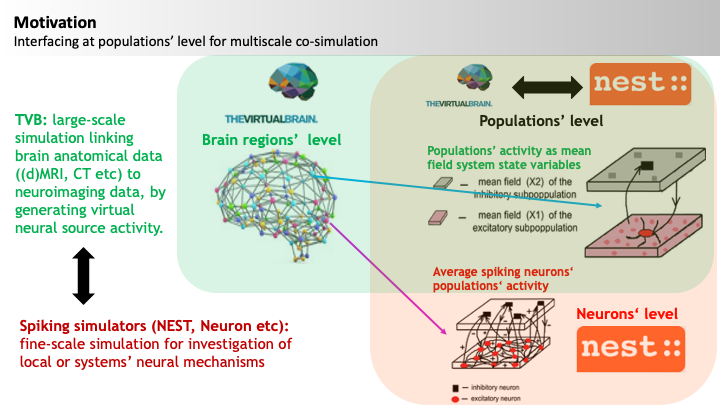

In [1]:
from IPython.core.display import Image, display
display(Image(filename='../pics/ConceptGraph1.png',  width=1000, unconfined=False))

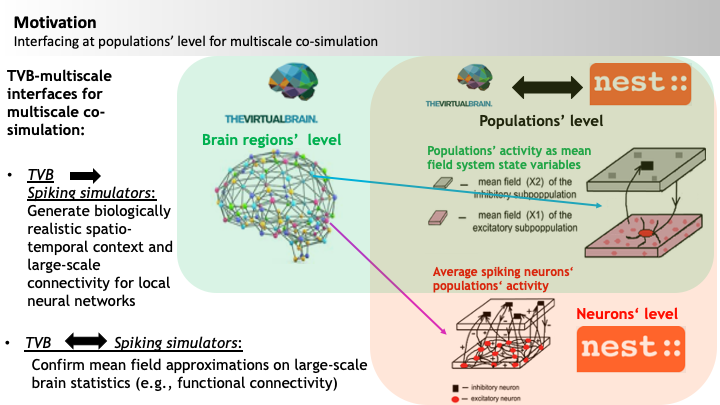

In [2]:
display(Image(filename='../pics/ConceptGraph2.png',  width=1000, unconfined=False))

## tvb-multiscale toolbox:

### https://github.com/the-virtual-brain/tvb-multiscale

For questions use the git issue tracker, or write an e-mail to me: dionysios.perdikis@charite.de

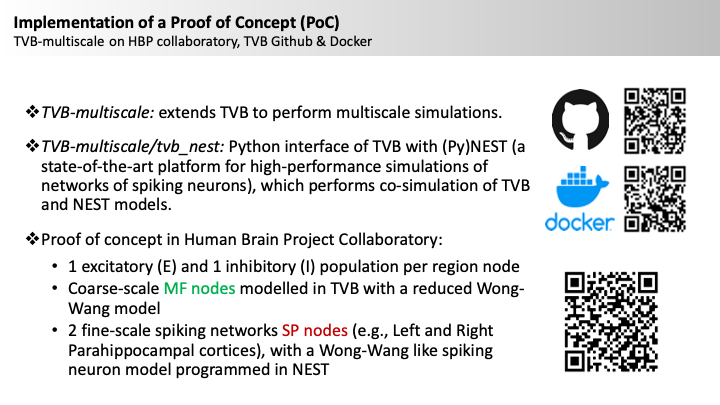

In [3]:
display(Image(filename='../pics/Overview.png',  width=1000, unconfined=False))

# TVB - NEST co-simulation 

## Linear TVB mean field model

For every region node $n\prime$ modelled as a mean-field node in TVB:

(Post)Synaptic gating dynamics (i.e., proportion of synapse channels open at any given time):

$\dot{R_{n\prime}} =  (\gamma{R_{n\prime}}(t) + {\sum_{{m\prime}\neq {n\prime}}C_{{m\prime}{n\prime}}R_{m\prime}(t-\tau_{{m\prime}{n\prime}})}(t))$


## Cerebellum Spiking network model in NEST

To be filled in!...

## TVB to NEST coupling
TVB couples to NEST via instantaneous spike rate $ interface_{weight} * R(t) $, 

Spike generator NEST devices are used as TVB "proxy" nodes and generate spike trains 

$ \left[ \sum_k \delta(t-\tau_{n\prime n}-{t_j}^k) \right]_{j \in n\prime} $



## NEST to TVB update

A NEST spike detector device is used to count spike for each time step, and convert it to an instantaneous population mean rate that overrides

$ {R_{_{n}}}(t) =  \frac{\sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in R_n}}{nNeurons * dt} $ in  spikes/sec.

This update process concerns only the TVB region nodes that are simulated exclusively in NEST, as spiking networks. All the rest of TVB nodes will follow the equations of the mean field model described above.


## Simulator loop

### Simulating several (i.e., 4) NEST time steps for every 1 TVB time step for stable integration

# WORKFLOW:

In [4]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *

CEREB_TO_REST_OF_BRAIN_CONNS_SCALE = 100

SIM_MODE = "tvb-nest"
if SIM_MODE.lower() == "nest":
    BACKGROUND = True
else:
    BACKGROUND = False 
STIMULUS = True
NEST_MODEL_BUILDERS = True

work_path = os.getcwd()
data_path = os.path.join(work_path.split("tvb_nest")[0], "data", "cerebellum")
tvb_conn_filepath = os.path.join(data_path, "Connectivity_res100_summ49regions_IOsplit.h5")
outputs_path = os.path.join(work_path, "outputs/cereb")
if NEST_MODEL_BUILDERS is False:
    outputs_path += "NoNestBuilders"
if STIMULUS:
    outputs_path += "Stim"
else:
    outputs_path += "Rest"
if SIM_MODE.lower() == "nest":
    outputs_path += "NESTonly"
elif SIM_MODE.lower() == "tvb":
    outputs_path += "TVBonly"
    
config = Config(output_base=outputs_path)
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

2021-06-03 20:13:06,053 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2021-06-03 20:13:06,053 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2021-06-03 20:13:06,056 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2021-06-03 20:13:06,056 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2021-06-03 20:13:06,060 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2021-06-03 20:13:06,060 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2021-06-03 20:13:06,064 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2021-06-03 20:13:06,064 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2021-06-03 20:13:06,068 - INFO - tvb_multiscale.tv

## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

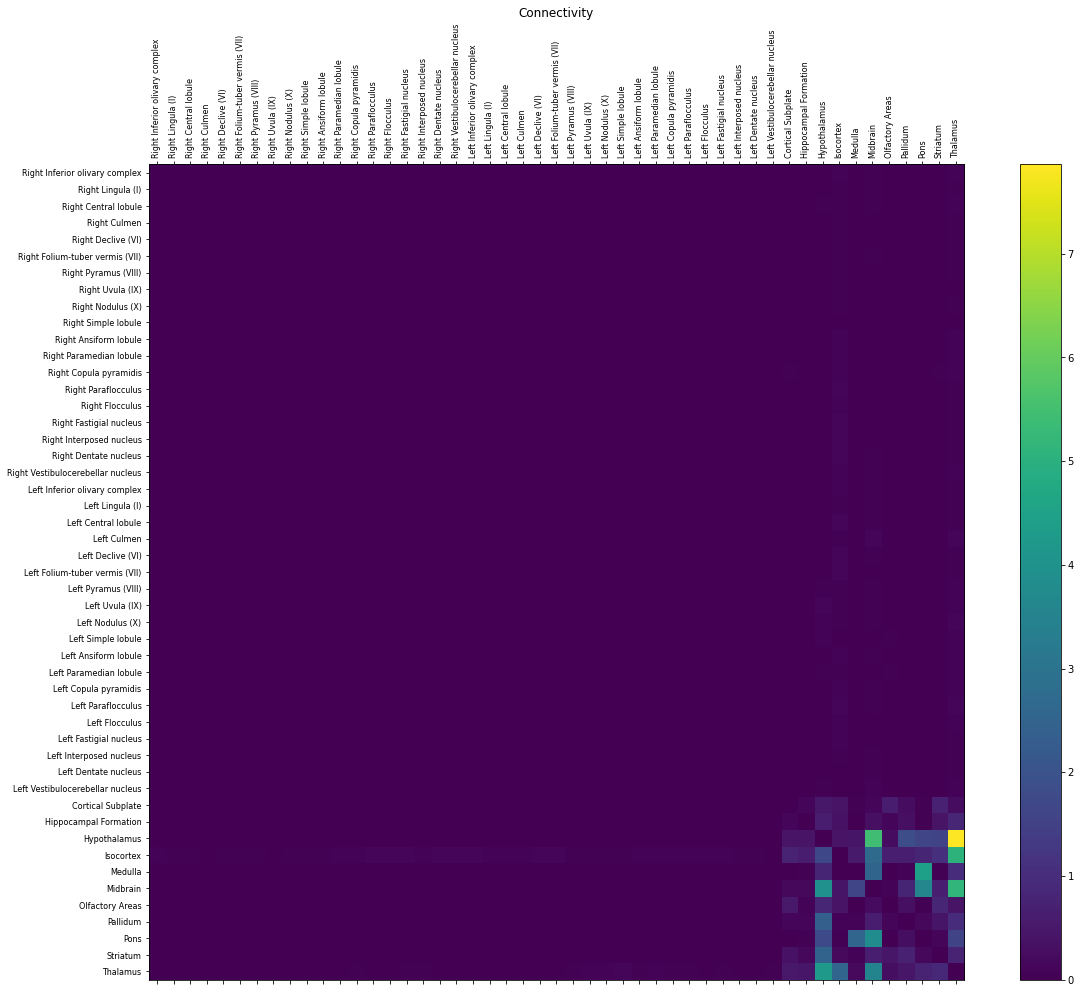

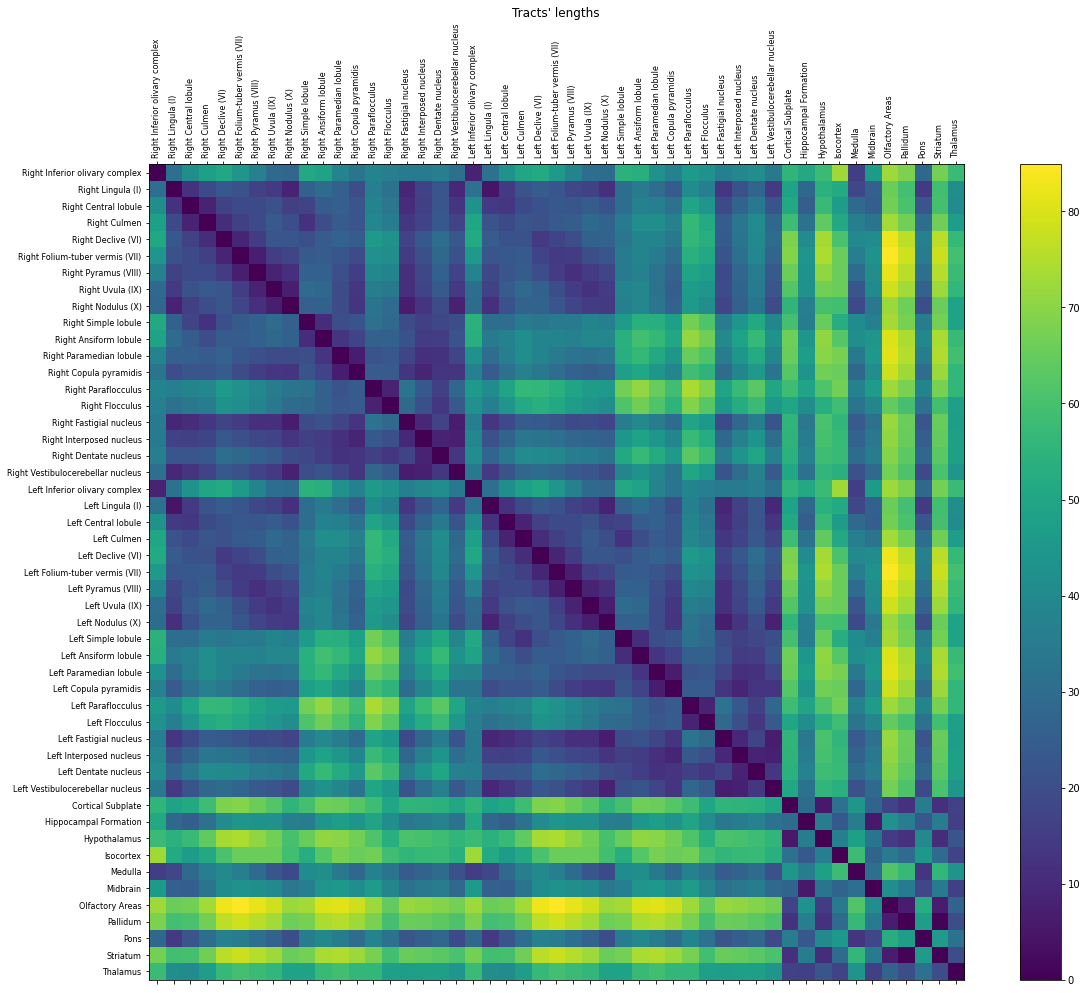

In [5]:
from tvb_multiscale.core.tvb.cosimulator.models.linear import Linear
from tvb.datatypes.connectivity import Connectivity
from tvb_multiscale.core.tvb.cosimulator.cosimulator_serial import CoSimulatorSerial
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG


# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = CoSimulatorSerial()
model_params = {"I_o": np.array([1.0]), "G": np.array([4.0]), # *256, 
                "tau": np.array([10.0]), "gamma": np.array([-1.0])}

simulator.model = Linear(**model_params)

simulator.integrator = HeunStochastic()
simulator.integrator.dt = 0.1
simulator.integrator.noise.nsig = np.array([0.001])


# Load connectivity
# config.DEFAULT_CONNECTIVITY_ZIP = "/home/docker/packages/tvb_data/tvb_data/mouse/allen_2mm/ConnectivityAllen2mm.zip"                                  
# connectivity = Connectivity.from_file(config.DEFAULT_CONNECTIVITY_ZIP)
import h5py
f = h5py.File(tvb_conn_filepath)
connectivity = Connectivity(weights=np.array(f["weights"][()]), tract_lengths=np.array(f["tract_lengths"][()]), 
                            centres=np.array(f["centres"][()]), # hemispheres=np.array(f["hemispheres"][()]), 
                            region_labels=np.array(f["region_labels"][()]).astype("<U128"))
f.close()

# Normalize connectivity weights
connectivity.weights[np.isnan(connectivity.weights)] = 0.0
connectivity.weights = connectivity.scaled_weights(mode="region")
connectivity.weights /= np.percentile(connectivity.weights, 99)
# connectivity.weights[connectivity.weights > 1.0] = 1.0
connectivity.configure()

simulator.connectivity = connectivity

simulator.model.I_o = simulator.model.I_o[0] * np.ones((connectivity.number_of_regions, ))

simulator.initial_conditions = np.zeros((1, 1, connectivity.number_of_regions, 1))

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, )

simulator.configure()

plotter.plot_tvb_connectivity(simulator.connectivity);

In [6]:
# Select the regions for the fine scale modeling with NEST spiking networks
ordered_populations_labels = ['mossy_fibers', 'glomerulus', "granule_cell", "golgi_cell",
                              'io_cell', "basket_cell", "stellate_cell", "purkinje_cell",
                              'dcn_cell_GABA', 'dcn_cell_Gly-I', 'dcn_cell_glut_large']

region_labels = connectivity.region_labels.tolist()

cereberal_cortex = "Ansiform lobule"
inferior_olive = "Inferior olivary complex" 
cereberal_nucleus = "Interposed nucleus"

hemisphere = "Right"
cereberal_cortex = "%s %s" % (hemisphere, cereberal_cortex)
inferior_olive = "%s %s" % (hemisphere, inferior_olive)
cereberal_nucleus = "%s %s" % (hemisphere, cereberal_nucleus)
cereb_ctx_id = region_labels.index(cereberal_cortex)
pops_to_nodes_inds = dict(zip(ordered_populations_labels, [cereb_ctx_id] * len(ordered_populations_labels)))
io_ctx_id = region_labels.index(inferior_olive)
pops_to_nodes_inds['io_cell'] = io_ctx_id
dcn_cells = ['dcn_cell_GABA', 'dcn_cell_Gly-I', 'dcn_cell_glut_large']
cereberal_nucleus_id = region_labels.index(cereberal_nucleus)
for dcn in dcn_cells:
    pops_to_nodes_inds[dcn] = cereberal_nucleus_id
number_of_regions = simulator.connectivity.region_labels.shape[0]
nest_nodes_ids = np.unique(list(pops_to_nodes_inds.values())).astype("i")

nodes_inds_to_nodes_labels = dict(zip(nest_nodes_ids, connectivity.region_labels[nest_nodes_ids]))
print(nodes_inds_to_nodes_labels)
print(pops_to_nodes_inds)

{0: 'Right Inferior olivary complex', 10: 'Right Ansiform lobule', 16: 'Right Interposed nucleus'}
{'mossy_fibers': 10, 'glomerulus': 10, 'granule_cell': 10, 'golgi_cell': 10, 'io_cell': 0, 'basket_cell': 10, 'stellate_cell': 10, 'purkinje_cell': 10, 'dcn_cell_GABA': 16, 'dcn_cell_Gly-I': 16, 'dcn_cell_glut_large': 16}


In [7]:
connections_from_cereb_nuclei = simulator.connectivity.weights[nest_nodes_ids[-1], :]
sorted_connections_from_cereb = np.argsort(connections_from_cereb_nuclei)[::-1]
print("sorted connections_from_cereb_nuclei =\n") 
for conn_id in sorted_connections_from_cereb:
    print("\n%d. %s, w = %g" % 
          (conn_id, simulator.connectivity.region_labels[conn_id], connections_from_cereb_nuclei[conn_id]))
connections_to_cereb_ctx = simulator.connectivity.weights[:, nest_nodes_ids[0]]
sorted_connections_to_cereb = np.argsort(connections_to_cereb_ctx)[::-1]
print("\n\nsorted connections_to_cereb_ctx =\n") 
for conn_id in sorted_connections_to_cereb:
    print("\n%d. %s, w = %g" % 
          (conn_id, simulator.connectivity.region_labels[conn_id], connections_to_cereb_ctx[conn_id]))


sorted connections_from_cereb_nuclei =


41. Isocortex, w = 0.123346

48. Thalamus, w = 0.0597846

43. Midbrain, w = 0.0255251

38. Cortical Subplate, w = 0.0183547

47. Striatum, w = 0.0143178

44. Olfactory Areas, w = 0.0084659

39. Hippocampal Formation, w = 0.00835036

40. Hypothalamus, w = 0.00788205

45. Pallidum, w = 0.00646799

46. Pons, w = 0.00260693

17. Right Dentate nucleus, w = 0.00180122

19. Left Inferior olivary complex, w = 0.00136699

18. Right Vestibulocerebellar nucleus, w = 0.00134553

42. Medulla, w = 0.00113113

13. Right Paraflocculus, w = 0.000994323

12. Right Copula pyramidis, w = 0.000555901

10. Right Ansiform lobule, w = 0.00024201

9. Right Simple lobule, w = 0.000208219

3. Right Culmen, w = 0.000170453

11. Right Paramedian lobule, w = 0.000159909

15. Right Fastigial nucleus, w = 0.000147268

14. Right Flocculus, w = 0.000144621

20. Left Lingula (I), w = 0.000114436

1. Right Lingula (I), w = 0.000109704

0. Right Inferior olivary complex, w = 9.5869

In [8]:
all_other_regions_inds = np.arange(connectivity.number_of_regions-1, connectivity.number_of_regions-12, -1)
print("All non-cerebellar regions:\n%s" % str(connectivity.region_labels[all_other_regions_inds]))

All non-cerebellar regions:
['Thalamus' 'Striatum' 'Pons' 'Pallidum' 'Olfactory Areas' 'Midbrain'
 'Medulla' 'Isocortex' 'Hypothalamus' 'Hippocampal Formation'
 'Cortical Subplate']


In [9]:
simulator.connectivity.weights[nest_nodes_ids[-1:]][:, all_other_regions_inds]

array([[0.05978457, 0.01431785, 0.00260693, 0.00646799, 0.0084659 ,
        0.02552515, 0.00113113, 0.12334583, 0.00788205, 0.00835036,
        0.01835473]])

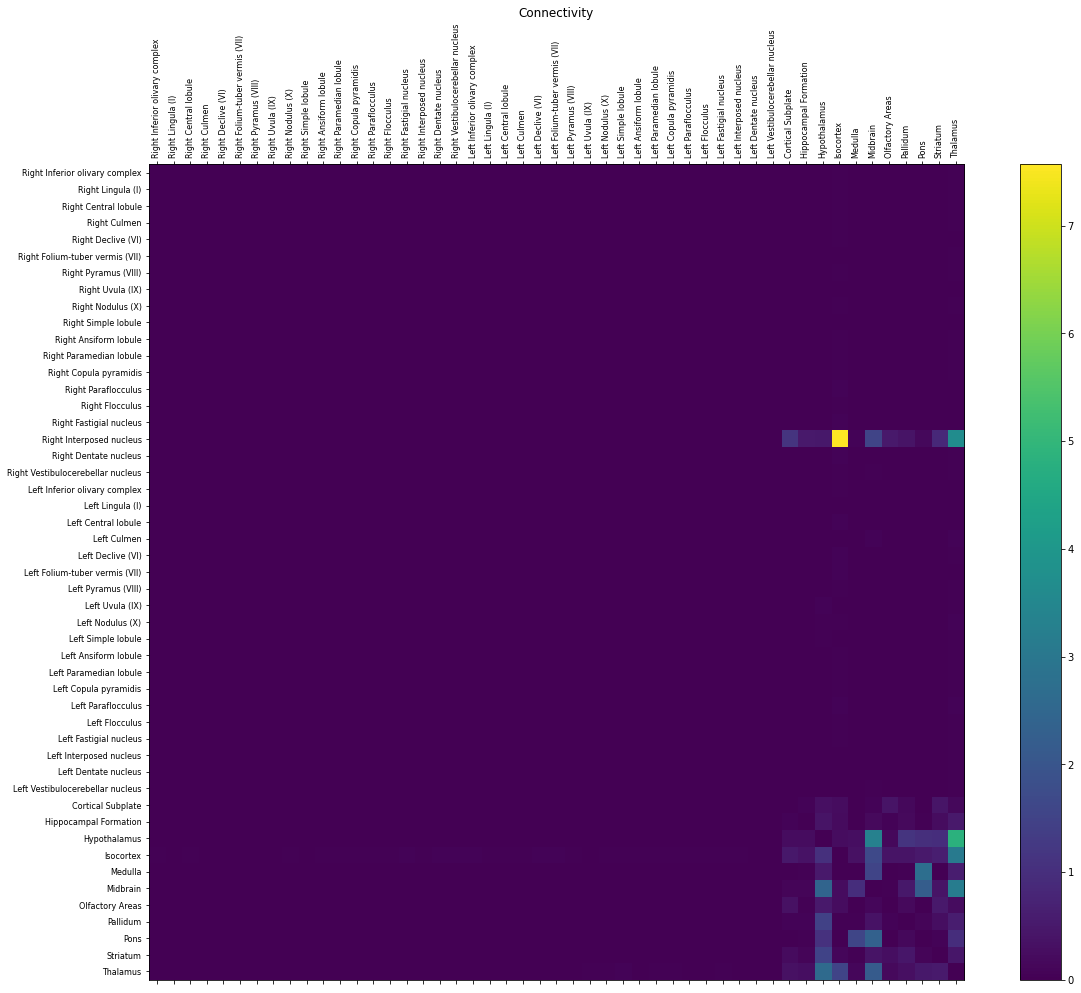

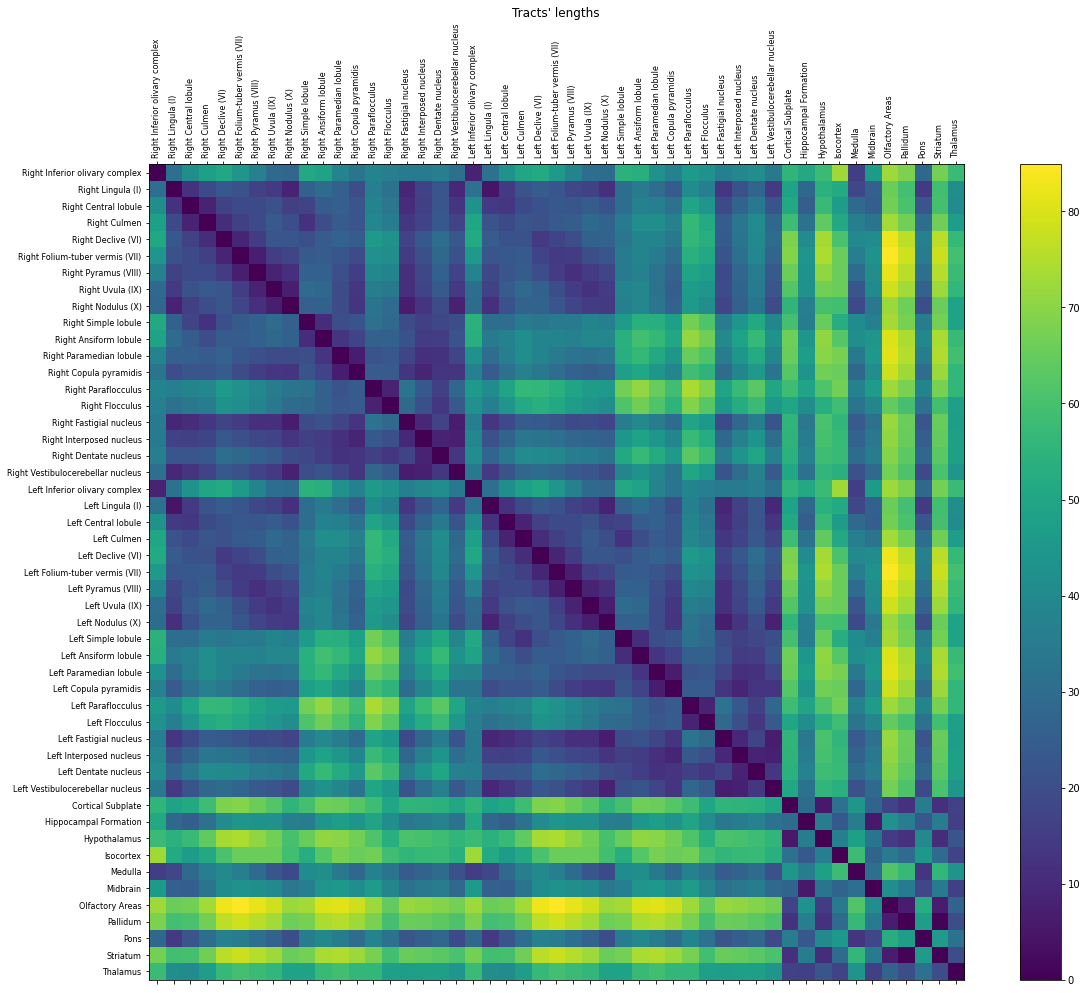

In [10]:
if CEREB_TO_REST_OF_BRAIN_CONNS_SCALE != 1.0:
    # Normalize connectivity weights
    simulator.connectivity.weights[nest_nodes_ids[-1:], all_other_regions_inds] *= CEREB_TO_REST_OF_BRAIN_CONNS_SCALE
    simulator.connectivity.weights = simulator.connectivity.scaled_weights(mode="region")
    simulator.connectivity.weights /= np.percentile(simulator.connectivity.weights, 99)
    # connectivity.weights[connectivity.weights > 1.0] = 1.0
    simulator.connectivity.configure()

    simulator.configure()

    plotter.plot_tvb_connectivity(simulator.connectivity)
    


In [11]:
simulator.connectivity.weights[nest_nodes_ids[-1:]][:, all_other_regions_inds]

array([[3.66859213, 0.87859368, 0.1599704 , 0.39689899, 0.51949765,
        1.56631322, 0.06940996, 7.56893553, 0.48367037, 0.51240784,
        1.12631084]])

In [12]:
if CEREB_TO_REST_OF_BRAIN_CONNS_SCALE != 1.0:
    connections_from_cereb_nuclei = simulator.connectivity.weights[nest_nodes_ids[-1], :]
    sorted_connections_from_cereb = np.argsort(connections_from_cereb_nuclei)[::-1]
    print("sorted connections_from_cereb_nuclei =\n") 
    for conn_id in sorted_connections_from_cereb:
        print("\n%d. %s, w = %g" % 
              (conn_id, simulator.connectivity.region_labels[conn_id], connections_from_cereb_nuclei[conn_id]))


sorted connections_from_cereb_nuclei =


41. Isocortex, w = 7.56894

48. Thalamus, w = 3.66859

43. Midbrain, w = 1.56631

38. Cortical Subplate, w = 1.12631

47. Striatum, w = 0.878594

44. Olfactory Areas, w = 0.519498

39. Hippocampal Formation, w = 0.512408

40. Hypothalamus, w = 0.48367

45. Pallidum, w = 0.396899

46. Pons, w = 0.15997

42. Medulla, w = 0.06941

17. Right Dentate nucleus, w = 0.00110529

19. Left Inferior olivary complex, w = 0.000838835

18. Right Vestibulocerebellar nucleus, w = 0.000825666

13. Right Paraflocculus, w = 0.000610152

12. Right Copula pyramidis, w = 0.000341121

10. Right Ansiform lobule, w = 0.000148506

9. Right Simple lobule, w = 0.00012777

3. Right Culmen, w = 0.000104596

11. Right Paramedian lobule, w = 9.8126e-05

15. Right Fastigial nucleus, w = 9.03687e-05

14. Right Flocculus, w = 8.87448e-05

20. Left Lingula (I), w = 7.02221e-05

1. Right Lingula (I), w = 6.7318e-05

0. Right Inferior olivary complex, w = 5.88291e-05

8. Right Nodulu

## 2. Build and connect the NEST network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [13]:
# Build a NEST network model with the corresponding builder
from tvb_multiscale.tvb_nest.nest_models.builders.nest_factory import load_nest, configure_nest_kernel
from tvb_multiscale.tvb_nest.nest_models.models.cereb import CerebBuilder
from tvb_multiscale.tvb_nest.nest_models.models.cereb_no_tvb_nest_builders \
    import CerebBuilder as CerebBuilderNoNESTbuilder

nest = load_nest(config=config)
nest = configure_nest_kernel(nest, config)

# Using all default parameters for this example
if NEST_MODEL_BUILDERS:
    nest_model_builder = CerebBuilder(
        simulator, spiking_nodes_inds=[], nest_instance=nest, config=config, 
        pops_to_nodes_inds=pops_to_nodes_inds, 
        path_to_network_source_file=os.path.join(data_path, "300x_200z_DCN_IO.hdf5"))
else:
    nest_model_builder = CerebBuilderNoNESTbuilder(
        simulator, nest_instance=nest, config=config, 
        pops_to_nodes_inds=pops_to_nodes_inds, nodes_inds_to_nodes_labels=nodes_inds_to_nodes_labels,
        path_to_network_source_file=os.path.join(data_path, "300x_200z_DCN_IO.hdf5"))

nest_model_builder.STIMULUS = STIMULUS
nest_model_builder.BACKGROUND = BACKGROUND

nest_model_builder.configure()
nest_network = nest_model_builder.build(set_defaults=True)
nest_network.configure()

# # or...



2021-06-03 20:13:20,183 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring spiking network builder...
2021-06-03 20:13:20,183 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring spiking network builder...
2021-06-03 20:13:20,186 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring populations...
2021-06-03 20:13:20,186 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring populations...
2021-06-03 20:13:20,190 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring populations' connections within spiking region nodes...
2021-06-03 20:13:20,190 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring populations' connections within spiking region nodes...
2021-06-03 20:13:20,194 - INFO - tvb_multiscale.core.spiking_models.builders.base - Configuring populations' connections among spiking region nodes...
2021-06-03 20:13:20,194 - INFO - tvb_multiscale.core.spiking_models.builders.

2021-06-03 20:13:20,377 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating population: dcn_cell_glut_large...
2021-06-03 20:13:20,377 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating population: dcn_cell_glut_large...
2021-06-03 20:13:20,379 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - ...with 129 neurons...
2021-06-03 20:13:20,379 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - ...with 129 neurons...
2021-06-03 20:13:20,384 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting populations within spiking brain regions...
2021-06-03 20:13:20,384 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting populations within spiking brain regions...
2021-06-03 20:13:20,387 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting mossy_fibers -> glomerulus populations 
for spiking region nodes
[10]...
2021-06-03 20:13:20,387 - INFO - tvb_multiscale.core.spiking_models.builders.b

2021-06-03 20:13:23,816 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting stellate_cell -> purkinje_cell populations 
for spiking region nodes
[10]...
2021-06-03 20:13:23,816 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting stellate_cell -> purkinje_cell populations 
for spiking region nodes
[10]...
2021-06-03 20:13:23,829 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - ...5525 connections to receptor 2
2021-06-03 20:13:23,829 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - ...5525 connections to receptor 2
2021-06-03 20:13:23,835 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting stellate_cell -> stellate_cell populations 
for spiking region nodes
[10]...
2021-06-03 20:13:23,835 - INFO - tvb_multiscale.core.spiking_models.builders.base - Connecting stellate_cell -> stellate_cell populations 
for spiking region nodes
[10]...
2021-06-03 20:13:23,845 - INFO - tvb_multiscale.tvb_nest.nest_models.build

2021-06-03 20:13:23,982 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating and connecting output devices, if any...
2021-06-03 20:13:23,982 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating and connecting output devices, if any...
2021-06-03 20:13:23,985 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating and connecting ['mossy_fibers'] -> ['mossy_fibers'] device set of model spike_recorder
for nodes [1]...
2021-06-03 20:13:23,985 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating and connecting ['mossy_fibers'] -> ['mossy_fibers'] device set of model spike_recorder
for nodes [1]...
2021-06-03 20:13:25,713 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for mossy_fibers created!
2021-06-03 20:13:25,713 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'

2021-06-03 20:13:39,145 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating and connecting ['dcn_cell_glut_large'] -> ['dcn_cell_glut_large'] device set of model spike_recorder
for nodes [2]...
2021-06-03 20:13:39,169 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for dcn_cell_glut_large created!
2021-06-03 20:13:39,169 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for dcn_cell_glut_large created!
2021-06-03 20:13:39,339 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating and connecting ['granule_cell_ts'] -> ['granule_cell'] device set of model multimeter
for nodes [1]...
2021-06-03 20:13:39,339 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating and connecting ['granule_cell_ts'] -> ['granule_cell'] device set of model multimeter
for nodes [1

2021-06-03 20:13:51,363 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model poisson_generator for Stimulus_MF created!
2021-06-03 20:13:51,363 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model poisson_generator for Stimulus_MF created!
2021-06-03 20:13:51,473 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating and connecting ['Stimulus_IO'] -> [['io_cell']] device set of model poisson_generator
for nodes [0]...
2021-06-03 20:13:51,473 - INFO - tvb_multiscale.core.spiking_models.builders.base - Generating and connecting ['Stimulus_IO'] -> [['io_cell']] device set of model poisson_generator
for nodes [0]...
2021-06-03 20:13:51,479 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model poisson_generator for Stimulus_IO created!
2021-06-03 20:13:51,479 -

## 3. Build the TVB-NEST interface

In [14]:
if np.all(SIM_MODE.lower() == "tvb-nest"):
    from tvb_multiscale.tvb_nest.interfaces.models.cereb import CerebTVBNESTInterfaceBuilder


    # Build a TVB-NEST interface with all the appropriate connections between the
    # TVB and NEST modelled regions
    tvb_spikeNet_model_builder =  CerebTVBNESTInterfaceBuilder()
    tvb_spikeNet_model_builder.config = config
    tvb_spikeNet_model_builder.logger = nest_model_builder.logger
    tvb_spikeNet_model_builder.model = "RATE"
    tvb_spikeNet_model_builder.tvb_cosimulator = simulator
    tvb_spikeNet_model_builder.spiking_network = nest_network
    tvb_spikeNet_model_builder.input_flag = True
    tvb_spikeNet_model_builder.output_flag = True
    tvb_spikeNet_model_builder.N_mf = nest_network.brain_regions[cereberal_cortex]["mossy_fibers"].number_of_neurons
    tvb_spikeNet_model_builder.N_grc = nest_network.brain_regions[cereberal_cortex]["granule_cell"].number_of_neurons
    tvb_spikeNet_model_builder.N_io = nest_network.brain_regions[inferior_olive]["io_cell"].number_of_neurons
    tvb_spikeNet_model_builder.N_dcgl = nest_network.brain_regions[cereberal_nucleus]["dcn_cell_glut_large"].number_of_neurons
    tvb_spikeNet_model_builder.CC_proxy_inds = np.array([cereb_ctx_id])
    tvb_spikeNet_model_builder.CN_proxy_inds = np.array([cereberal_nucleus_id])
    tvb_spikeNet_model_builder.IO_proxy_inds = np.array([io_ctx_id])
    tvb_spikeNet_model_builder.proxy_inds = np.unique(
                                               tvb_spikeNet_model_builder.CC_proxy_inds.tolist() + 
                                               tvb_spikeNet_model_builder.CN_proxy_inds.tolist() + 
                                               tvb_spikeNet_model_builder.IO_proxy_inds.tolist())
    tvb_spikeNet_model_builder.exclusive_nodes = True


    # Using all default parameters for this example

    tvb_spikeNet_model_builder.output_interfaces = []
    tvb_spikeNet_model_builder.input_interfaces = []
    tvb_spikeNet_model_builder.default_config()


    # or...


    # ----------------------------------------------------------------------------------------------------------------
    # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
    # ----------------------------------------------------------------------------------------------------------------



    # # ----------------------------------------------------------------------------------------------------------------
    # # ----------------------------------------------------------------------------------------------------------------
    # # ----------------------------------------------------------------------------------------------------------------

    tvb_spikeNet_model_builder.configure()

    simulator = tvb_spikeNet_model_builder.build()
    simulator.simulate_spiking_simulator = nest_network.nest_instance.Run

    # Tune down the TVB -> NEST weight:
    simulator.output_interfaces.interfaces[0].transformer.scale_factor = np.array([0.0105])
    

2021-06-03 20:13:53,794 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model parrot_inhomogeneous_poisson_generator for R created!
2021-06-03 20:13:53,794 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model parrot_inhomogeneous_poisson_generator for R created!
2021-06-03 20:13:56,450 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for R created!
2021-06-03 20:13:56,450 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for R created!
2021-06-03 20:13:56,962 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for R created!
2021-06-03 20:13:56,962 - INFO - tvb_multiscale.core

In [15]:
# print(simulator.output_interfaces)
# for interface in simulator.output_interfaces.interfaces:
#     print(interface)
    
# print(simulator.input_interfaces)
# for interface in simulator.input_interfaces.interfaces:
#     print(interface)

## 4. Configure simulator, simulate, gather results

In [16]:
# Set the simulation and transient (to be optionally removed from resutls) times:
simulation_length = nest_model_builder.TOT_DURATION
simulator.simulation_length = simulation_length
transient = 0.1 * simulation_length

In [17]:
# Configure the simulator with the TVB-NEST interface...
# ...and simulate!
tic = time.time()
if np.all(SIM_MODE.lower() == "tvb"):
    # For TVB 
    results = simulator.run()
else:
    nest_network.nest_instance.Prepare()
    if np.all(SIM_MODE.lower() == "nest"):
        print("Simulating only NEST...")
        # Integrate NEST for simulation_length + 1 NEST time step so that multimeters get the last time point
        # unless you plan to continue simulation later
        nest_network.nest_instance.Run(simulation_length + nest_network.nest_instance.GetKernelStatus("resolution"))
        results = None
    else:
        print("Simulating TVB-NEST...")
        simulator.configure()
        # Adjust simulation length to be an integer multiple of synchronization_time:
        simulator.simulation_length = \
            np.ceil(simulator.simulation_length / simulator.synchronization_time) * simulator.synchronization_time
        simulation_length = simulator.simulation_length
        results = simulator.run()
        nest_network.nest_instance.Run(nest_network.nest_instance.GetKernelStatus("resolution"))
    nest_network.nest_instance.Cleanup()
print("\nSimulated in %f secs!" % (time.time() - tic))

Simulating TVB-NEST...


/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 1 last spike(s) of the input spiketrain
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 4 last spike(s) of the input spiketrain
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 2 last spike(s) of the input spiketrain
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 3 last spike(s) of the input spiketrain
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 5 last spike(s) of the input spiketrain
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 57 last spike(s) of the input spiketrain
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169


Simulated in 403.688685 secs!


## 5. Plot results and write them to HDF5 files

In [18]:
from scipy.io import savemat
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9
# from examples.plot_write_results import plot_write_results
# plot_write_results(results, simulator, populations=populations, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

In [19]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.tvb.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = None
if results is not None:
    source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
            data=results[0][1], time=results[0][0],
            connectivity=simulator.connectivity,
            labels_ordering=["Time", "State Variable", "Region", "Neurons"],
            labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                               "Region": simulator.connectivity.region_labels.tolist()},
            sample_period=simulator.integrator.dt)
    source_ts.configure()

    t = source_ts.time

    # Write to file
    if writer:
        writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                        connectivity=source_ts.connectivity),
                               os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
    source_ts
    

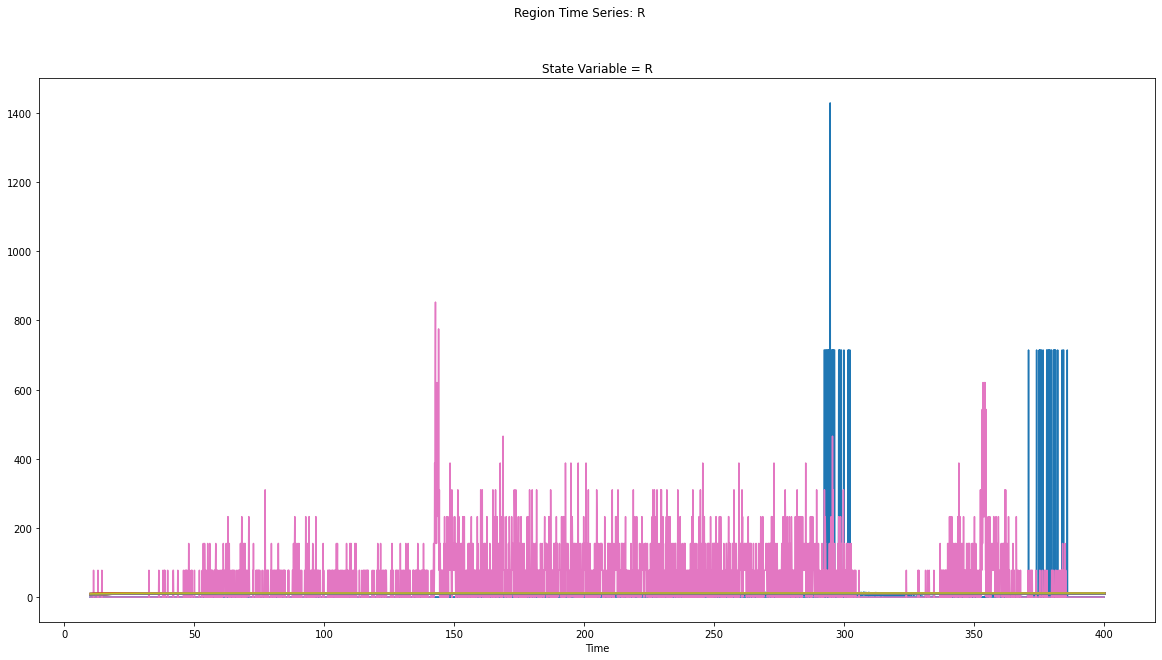

In [20]:
# Plot TVB time series
if source_ts is not None:
    source_ts[10.0:].plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

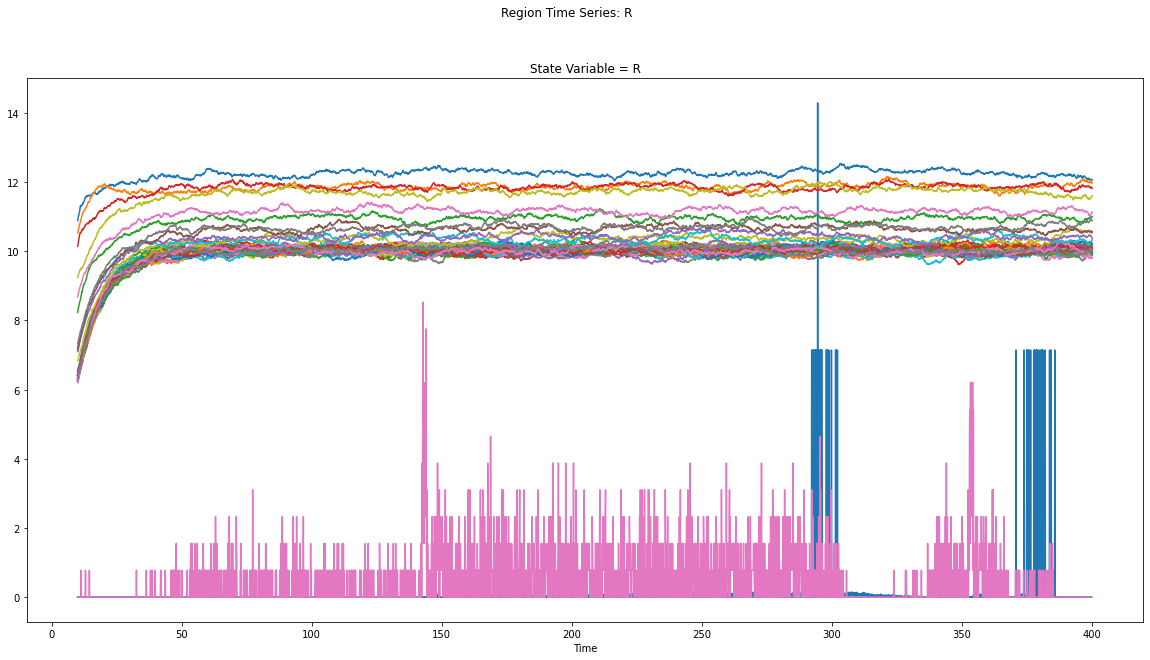

In [21]:
if source_ts is not None:
    source_ts_adj = TimeSeriesXarray()
    source_ts_adj.from_xarray_DataArray(
                              source_ts._data.copy(),
                               connectivity=source_ts.connectivity)
    source_ts_adj.data[:, :, nest_model_builder.spiking_nodes_inds] *= 0.01
    source_ts_adj[10.0:].plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);


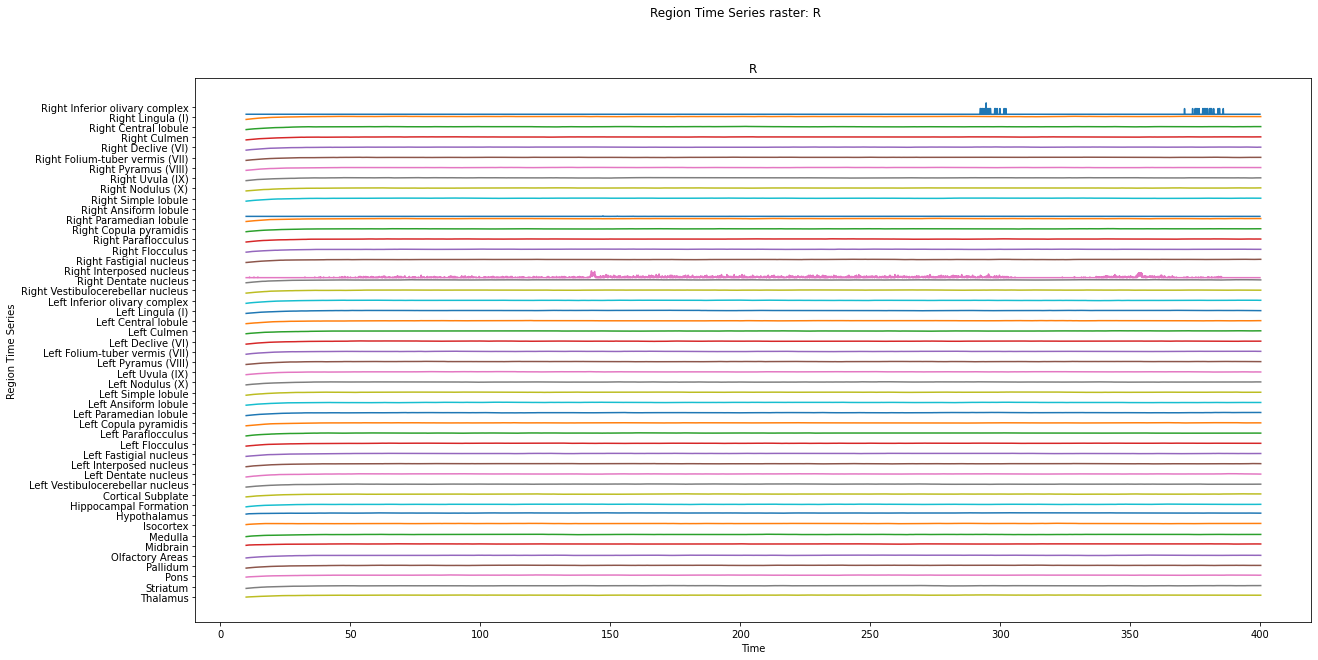

In [22]:
# TVB time series raster plot:
if source_ts is not None and source_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_adj[10.0:].plot_raster(plotter_config=plotter.config, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS,
                          figsize=FIGSIZE);

2021-06-03 20:20:43,958 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


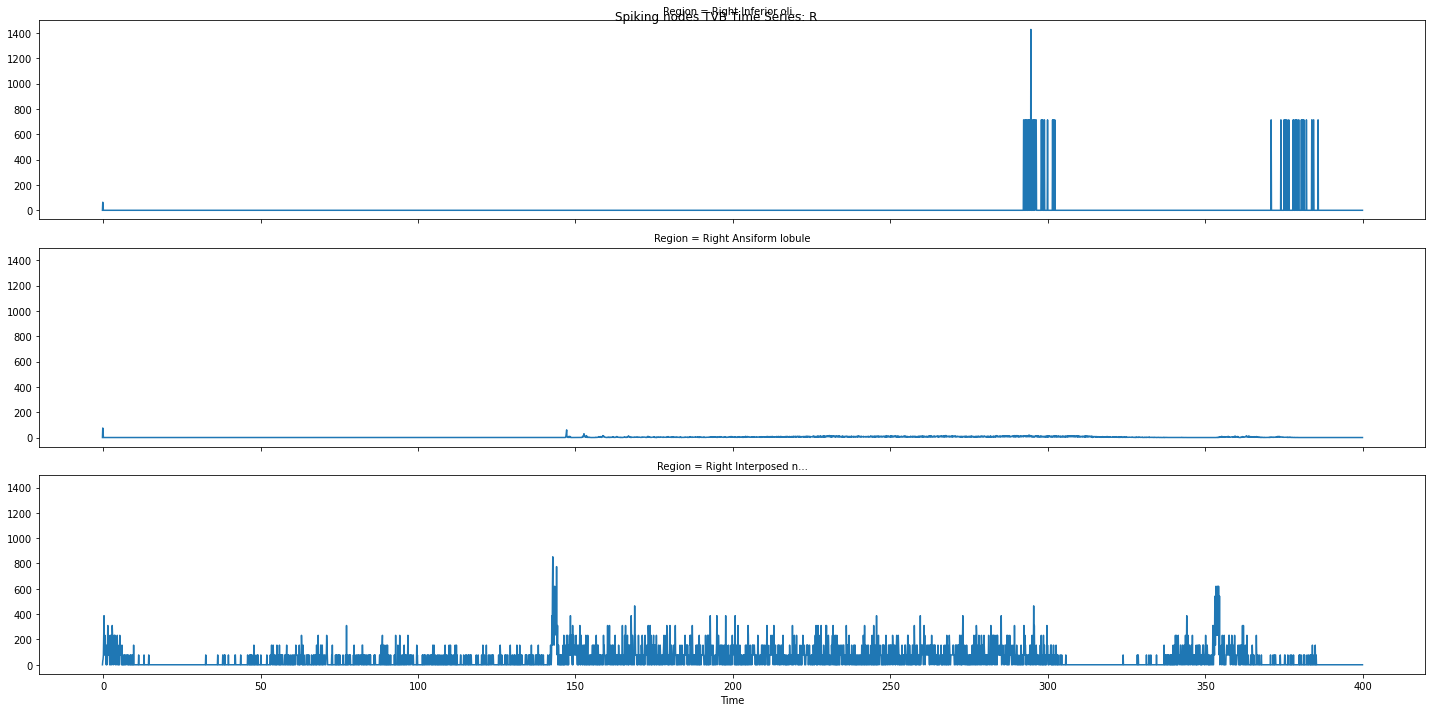

In [23]:
# Focus on the nodes modelled in NEST: 
if source_ts is not None:
    n_spiking_nodes = len(nest_model_builder.spiking_nodes_inds)
    source_ts_nest = source_ts[:, :, nest_model_builder.spiking_nodes_inds]
    source_ts_nest.plot_timeseries(plotter_config=plotter.config, 
                                   hue="Region" if source_ts_nest.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                                   per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS, 
                                   figsize=FIGSIZE, figname="Spiking nodes TVB Time Series");

In [24]:
# Focus on the nodes modelled in NEST: raster plot
if source_ts is not None and source_ts_nest.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_nest.plot_raster(plotter_config=plotter.config, 
                               per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS,
                               figsize=FIGSIZE, figname="Spiking nodes TVB Time Series Raster");

### Interactive time series plot

In [25]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)

### Spiking Network plots

In [26]:
from tvb_multiscale.core.data_analysis.spiking_network_analyser import SpikingNetworkAnalyser
# Create a SpikingNetworkAnalyzer:
spikeNet_analyzer = \
    SpikingNetworkAnalyser(spikeNet=nest_network,
                           start_time=0.0, end_time=simulation_length, 
                           period=simulator.monitors[0].period, transient=transient,
                           time_series_output_type="TVB", return_data=True, 
                           force_homogeneous_results=True, connectivity=simulator.connectivity)

### Plot spikes' raster and mean spike rates and correlations

In [27]:
# Spikes rates and correlations per Population and Region
spikes_res = \
    spikeNet_analyzer.\
        compute_spikeNet_spikes_rates_and_correlations(
            populations_devices=None, regions=None,
            rates_methods=[], rates_kwargs=[{}],rate_results_names=[],
            corrs_methods=[], corrs_kwargs=[{}], corrs_results_names=[], bin_kwargs={},
            data_method=spikeNet_analyzer.get_spikes_from_device, data_kwargs={},
            return_devices=False
        );

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 119 last spike(s) of the input spiketrain


<xarray.DataArray "Mean Populations' Spikes' Rates" (Population: 11, Region: 3)>
array([[23.58613673,         nan,         nan],
       [23.79918606,         nan,         nan],
       [ 3.83677943,         nan,         nan],
       [30.41960799,         nan,         nan],
       [        nan, 13.68287452,         nan],
       [42.31365693,         nan,         nan],
       [33.04734708,         nan,         nan],
       [97.9733476 ,         nan,         nan],
       [        nan,         nan, 16.2608074 ],
       [        nan,         nan, 37.88744794],
       [        nan,         nan, 61.4860819 ]])
Coordinates:
  * Region      (Region) object 'Right Ansiform lobule' ... 'Right Interposed...
  * Population  (Population) object 'mossy_fibers' ... 'dcn_cell_glut_large'
<xarray.DataArray "Populations' Correlation Coefficient" (Population_i: 11, Population_j: 11, Region_i: 3, Region_j: 3)>
array([[[[ 1.        ,         nan,         nan],
         [        nan,         nan,         nan]

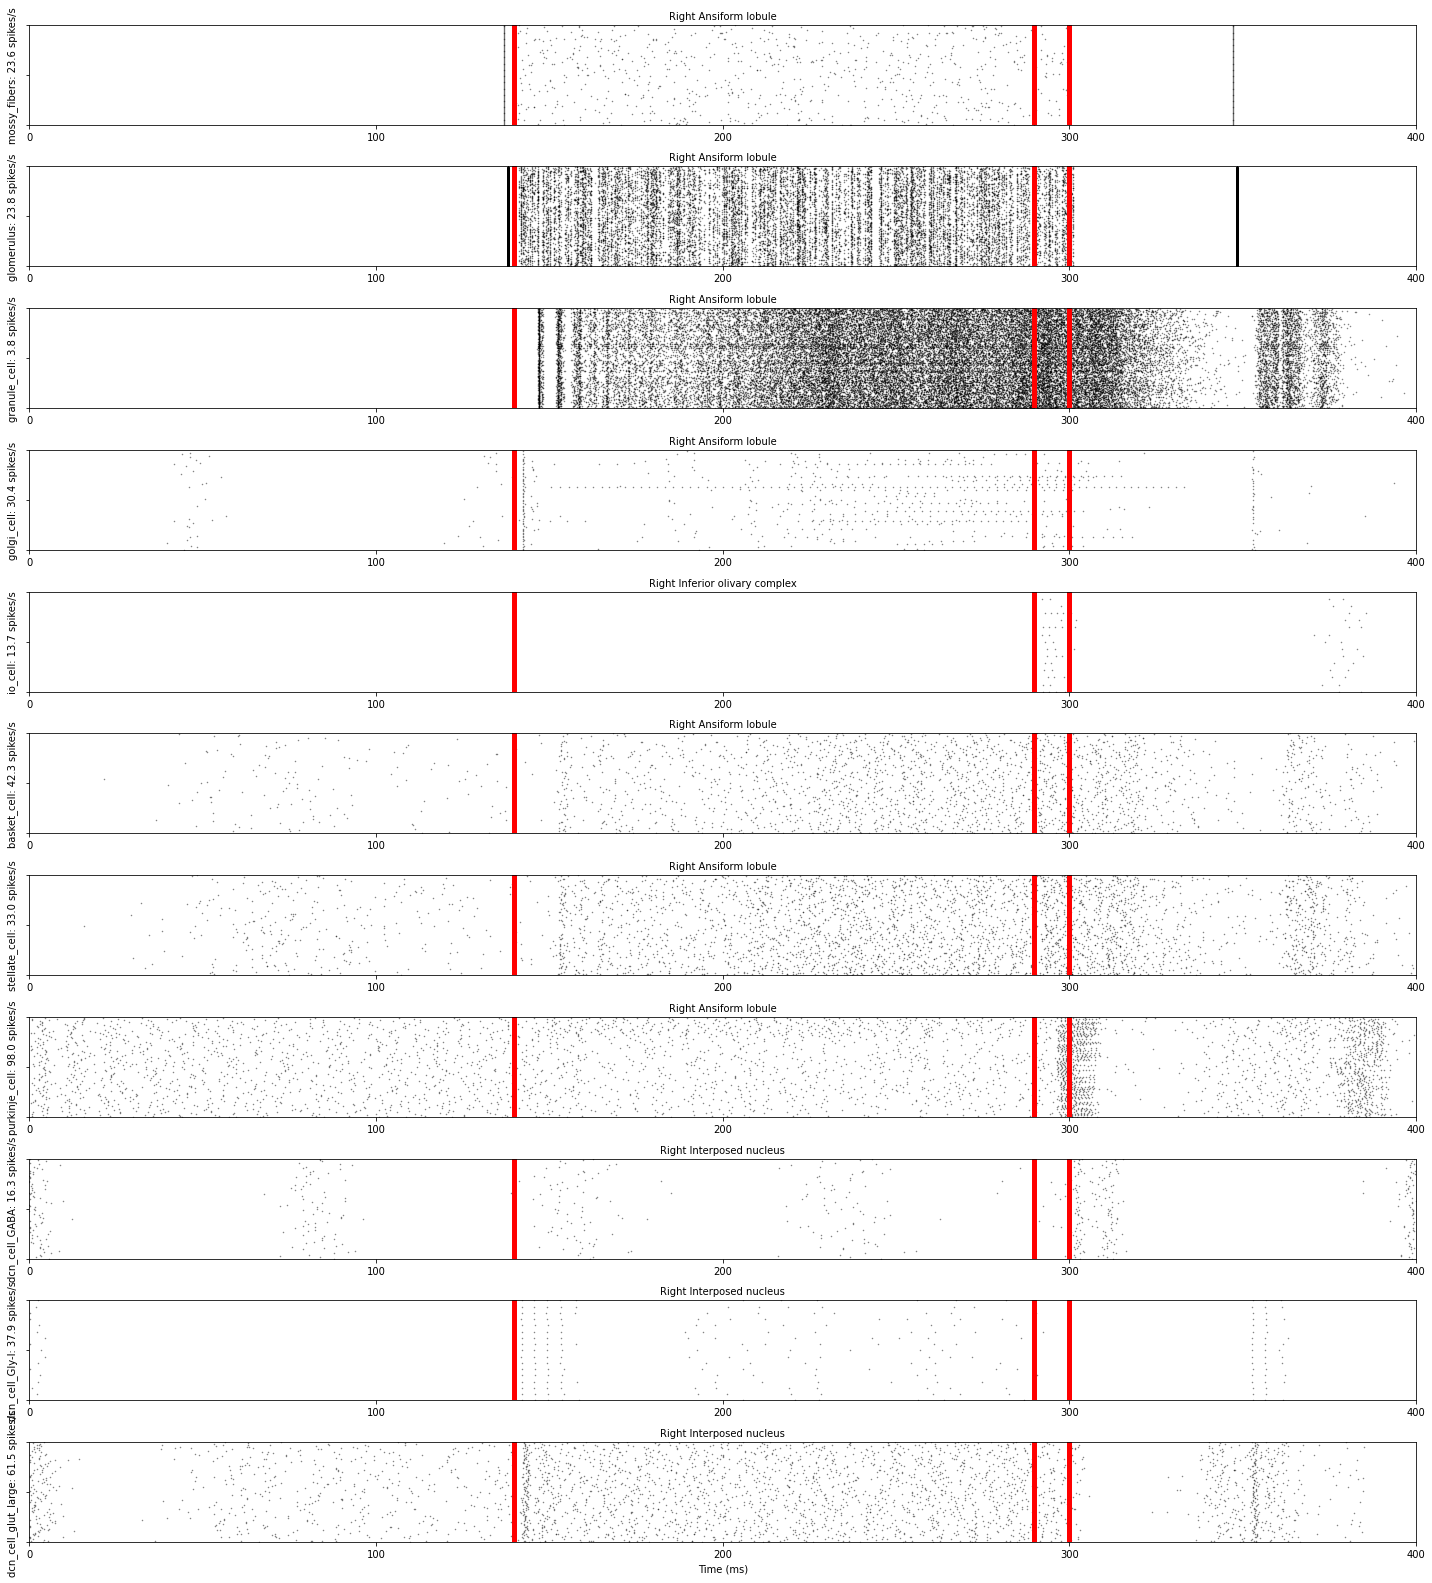

<Figure size 432x288 with 0 Axes>

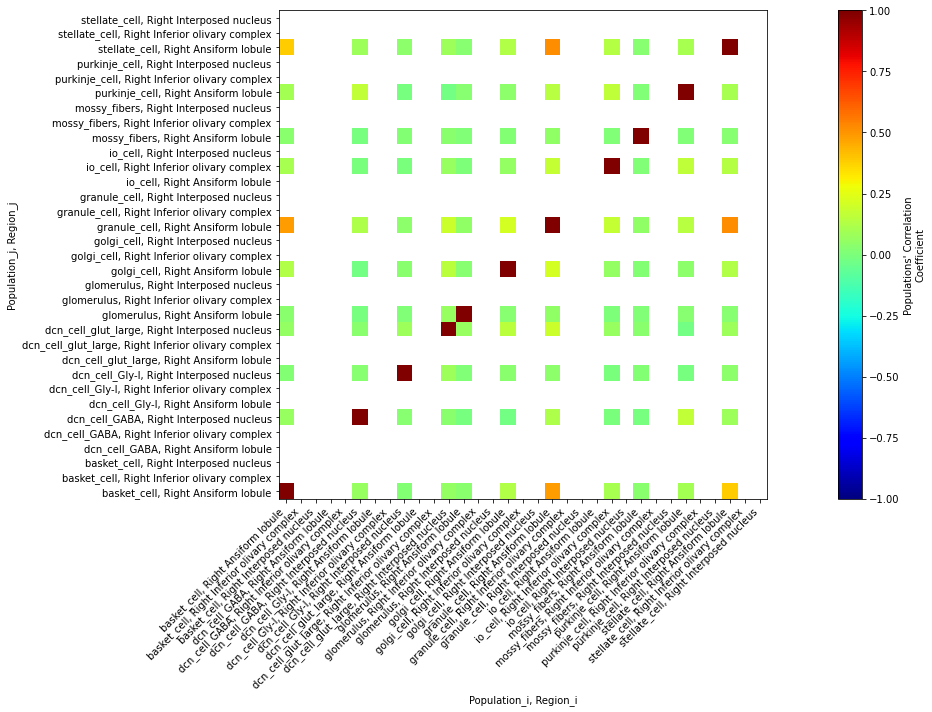

In [28]:
if spikes_res:
    print(spikes_res["mean_rate"])
    print(spikes_res["spikes_correlation_coefficient"])
    # Plot spikes' rasters together with mean population's spikes' rates' time series
    if plotter:
        plotter.plot_spike_events(spikes_res["spikes"], mean_results=spikes_res["mean_rate"], # time_series=spikes_res["mean_rate_time_series"], 
                                  figsize=(20, 22),  
                                  stimulus=[nest_model_builder.STIM_MF_START, 
                                            nest_model_builder.STIM_IO_START, 
                                            nest_model_builder.STIM_MF_END, 
                                            nest_model_builder.STIM_IO_END] if STIMULUS else None,
                                  stimulus_linewidth=5.0,
                                  spikes_markersize=0.5, spikes_alpha=0.5,
                                  n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                                  time_axis_min=0.0, time_axis_max=simulation_length)
        from tvb_multiscale.core.plot.correlations_plot import plot_correlations
        plot_correlations(spikes_res["spikes_correlation_coefficient"], plotter)

In [29]:
if spikes_res:
    print("Mean spike rates:")
    for pop in spikes_res["mean_rate"].coords["Population"]:
        for reg in spikes_res["mean_rate"].coords["Region"]:
            if not np.isnan(spikes_res["mean_rate"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_res["mean_rate"].loc[pop, reg].values.item()))

    # savemat(os.path.join(config.out.FOLDER_RES, "spikes_mean_rates.mat"), spikes_res["mean_rate"].to_dict())


Mean spike rates:
mossy_fibers - Right Ansiform lobule: 23.5861
glomerulus - Right Ansiform lobule: 23.7992
granule_cell - Right Ansiform lobule: 3.83678
golgi_cell - Right Ansiform lobule: 30.4196
io_cell - Right Inferior olivary complex: 13.6829
basket_cell - Right Ansiform lobule: 42.3137
stellate_cell - Right Ansiform lobule: 33.0473
purkinje_cell - Right Ansiform lobule: 97.9733
dcn_cell_GABA - Right Interposed nucleus: 16.2608
dcn_cell_Gly-I - Right Interposed nucleus: 37.8874
dcn_cell_glut_large - Right Interposed nucleus: 61.4861


In [30]:
spikes_sync = None
# spikeNet_analyzer.resample = True
# spikes_sync = \
#     spikeNet_analyzer.compute_spikeNet_synchronization(populations_devices=None, regions=None,
#                                                        comp_methods=[spikeNet_analyzer.compute_spikes_sync, 
#                                                                      spikeNet_analyzer.compute_spikes_sync_time_series, 
#                                                                      spikeNet_analyzer.compute_spikes_distance, 
#                                                                      spikeNet_analyzer.compute_spikes_distance_time_series,
#                                                                      spikeNet_analyzer.compute_spikes_isi_distance, 
#                                                                      spikeNet_analyzer.compute_spikes_isi_distance_time_series],
#                                                        computations_kwargs=[{}], data_kwargs={},
#                                                        return_spikes_trains=False, return_devices=False)
# # print(spikes_sync)


In [31]:
if spikes_sync:
    plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
    plotter.plot_spike_events(spikes_res["spikes"], 
                              time_series=spikes_sync["spikes_sync_time_series"], 
                              mean_results=spikes_sync["spikes_sync"], 
                              stistimulus=[nest_model_builder.STIM_MF_START, 
                                           nest_model_builder.STIM_IO_START, 
                                           nest_model_builder.STIM_MF_END, 
                                           nest_model_builder.STIM_IO_END] if STIMULUS else None,
                              stimulus_linewidth=5.0,
                              spikes_markersize=0.5, spikes_alpha=0.5,
                              n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                              time_axis_min=0.0, time_axis_max=simulation_length, figsize=(20, 22)
                              )

In [32]:
if spikes_sync:
    plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
    plotter.plot_spike_events(spikes_res["spikes"], 
                              time_series=spikes_sync["spikes_distance_time_series"], 
                              mean_results=spikes_sync["spikes_distance"], 
                              stimulus=[nest_model_builder.STIM_MF_START, 
                                        nest_model_builder.STIM_IO_START, 
                                        nest_model_builder.STIM_MF_END, 
                                        nest_model_builder.STIM_IO_END] if STIMULUS else None,
                              stimulus_linewidth=5.0,
                              spikes_markersize=0.5, spikes_alpha=0.5,
                              n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                              time_axis_min=0.0, time_axis_max=simulation_length, figsize=(20, 22)
                                     )

In [33]:
if spikes_sync:
    plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
    plotter.plot_spike_events(spikes_res["spikes"], 
                              time_series=spikes_sync["spikes_isi_distance_time_series"], 
                              mean_results=spikes_sync["spikes_isi_distance"], 
                              stimulus=[nest_model_builder.STIM_MF_START, 
                                        nest_model_builder.STIM_IO_START, 
                                        nest_model_builder.STIM_MF_END, 
                                        nest_model_builder.STIM_IO_END] if STIMULUS else None,
                              stimulus_linewidth=5.0,
                              spikes_markersize=0.5, spikes_alpha=0.5,
                              n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                              time_axis_min=0.0, time_axis_max=simulation_length, figsize=(20, 22)
                                     )

In [34]:
if spikes_sync:
    print("Spike synchronization:")
    for pop in spikes_sync["spikes_sync"].coords["Population"]:
        for reg in spikes_sync["spikes_sync"].coords["Region"]:
            if not np.isnan(spikes_sync["spikes_sync"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_sync["spikes_sync"].loc[pop, reg].values.item()))

#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_sync.mat"), spikes_sync["spikes_sync"].to_dict())
#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_sync_time_series.mat"), spikes_sync["spikes_sync_time_series"].to_dict())

In [35]:
if spikes_sync:
    print("Spike distance:")
    for pop in spikes_sync["spikes_distance"].coords["Population"]:
        for reg in spikes_sync["spikes_distance"].coords["Region"]:
            if not np.isnan(spikes_sync["spikes_distance"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_sync["spikes_distance"].loc[pop, reg].values.item()))

#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_distance.mat"), spikes_sync["spikes_distance"].to_dict())
#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_distance_time_series.mat"), spikes_sync["spikes_distance_time_series"].to_dict())

In [36]:
if spikes_sync:
    print("Spike ISI distance:")
    for pop in spikes_sync["spikes_isi_distance"].coords["Population"]:
        for reg in spikes_sync["spikes_isi_distance"].coords["Region"]:
            if not np.isnan(spikes_sync["spikes_isi_distance"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_sync["spikes_isi_distance"].loc[pop, reg].values.item()))

#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_isi_distance.mat"), spikes_sync["spikes_isi_distance"].to_dict())
#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_isi_distance_time_series.mat"), spikes_sync["spikes_isi_distance_time_series"].to_dict())

In [37]:
if spikes_res and writer:
    writer.write_object(spikes_res["spikes"].to_dict(), 
                        path=os.path.join(config.out.FOLDER_RES,  "Spikes") + ".h5");
    writer.write_object(spikes_res["mean_rate"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["mean_rate"].name) + ".h5");
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                              spikes_res["mean_rate_time_series"]._data,
                               connectivity=spikes_res["mean_rate_time_series"].connectivity),
                           os.path.join(config.out.FOLDER_RES,
                                        spikes_res["mean_rate_time_series"].title) + ".h5",
                           recursive=False);
    writer.write_object(spikes_res["spikes_correlation_coefficient"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["spikes_correlation_coefficient"].name) + ".h5");

### Get  SpikingNetwork mean field variable time series and plot them

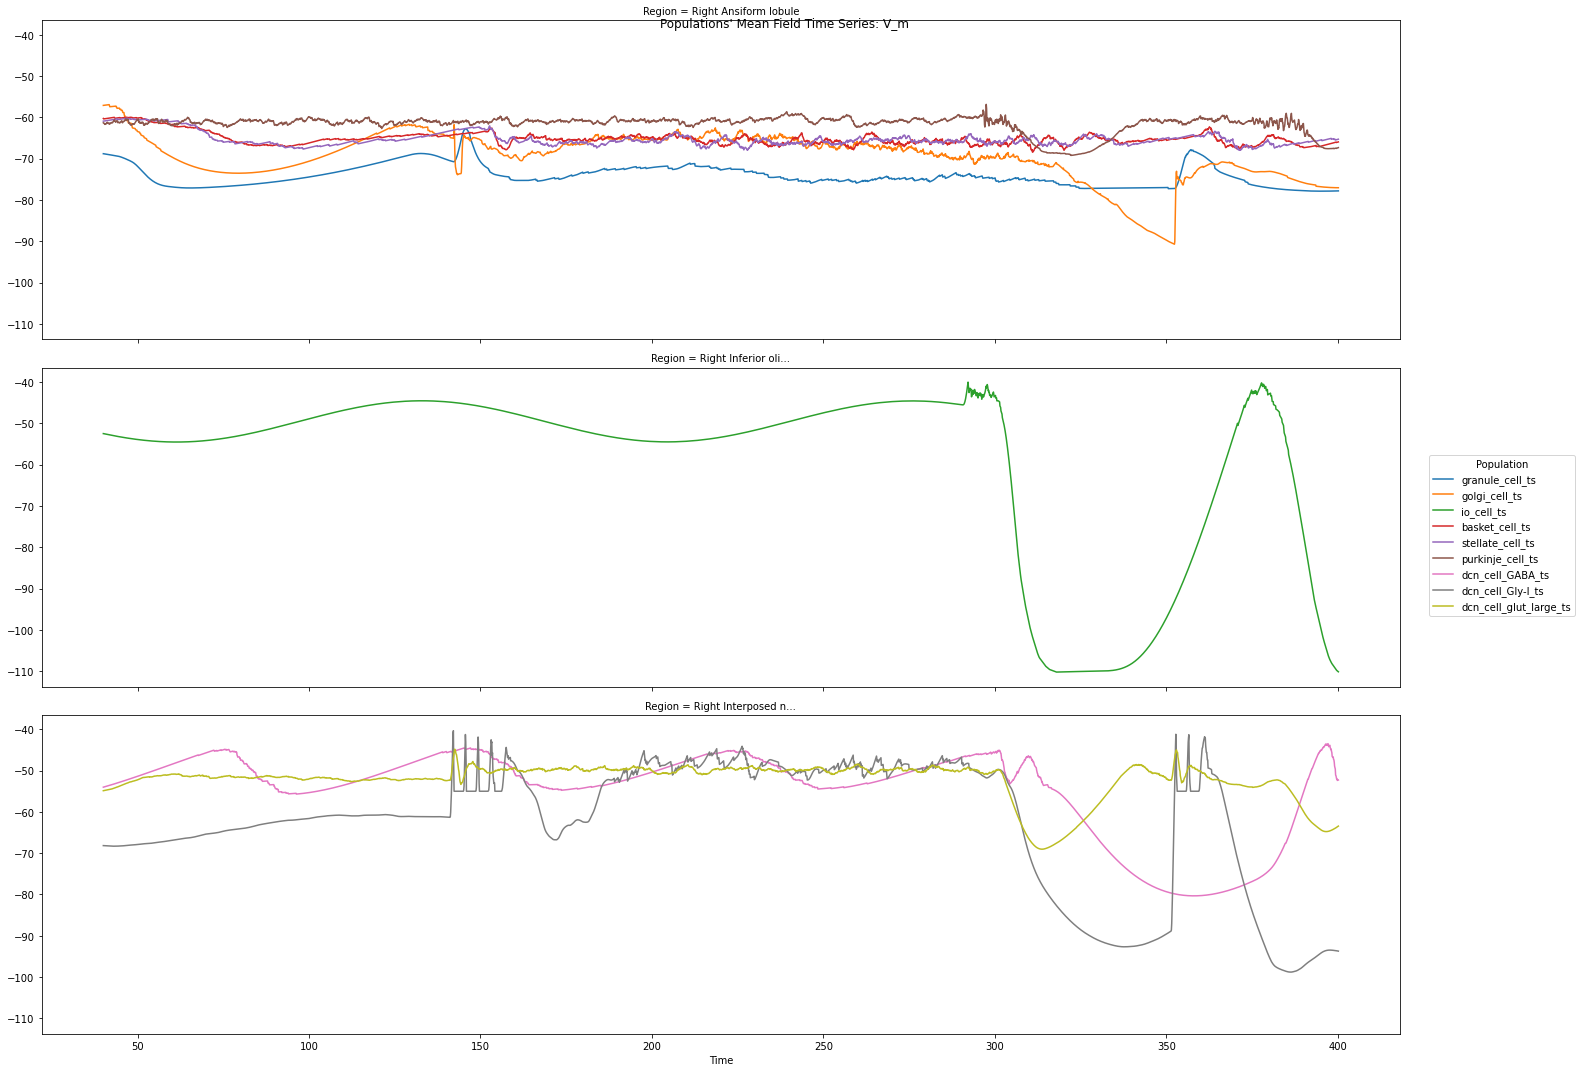

In [38]:
# Continuous time variables' data of spiking neurons
if plot_per_neuron:
    spikeNet_analyzer.return_data = True
else:
    spikeNet_analyzer.return_data = False
spikeNet_ts = \
    spikeNet_analyzer. \
         compute_spikeNet_mean_field_time_series(populations_devices=None, regions=None, variables=None,
                                                 computations_kwargs={}, data_kwargs={}, return_devices=False)
if spikeNet_ts:
    if plot_per_neuron:
        mean_field_ts = spikeNet_ts["mean_field_time_series"]  # mean field
        spikeNet_ts = spikeNet_ts["data_by_neuron"]  # per neuron data
    else:
        mean_field_ts = spikeNet_ts
        spikeNet_ts = None
    if mean_field_ts and mean_field_ts.size > 0:
        mean_field_ts.plot_timeseries(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS)
        if mean_field_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
            mean_field_ts.plot_raster(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS,
                                      linestyle="--", alpha=0.5, linewidth=0.5)
else:
    mean_field_ts = None

In [39]:
# Write results to file:
if mean_field_ts and writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                                       mean_field_ts._data,
                                       connectivity=mean_field_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, mean_field_ts.title) + ".h5", 
                           recursive=False)

### Compute per neuron spikes' rates times series and plot them

In [40]:
if spikes_res and plot_per_neuron:
    from tvb.simulator.plot.base_plotter import pyplot
    spikeNet_analyzer.return_data = False
    rates_ts_per_neuron = \
        spikeNet_analyzer. \
            compute_spikeNet_rates_time_series(populations_devices=None, regions=None,
                                               computations_kwargs={}, data_kwargs={},
                                               return_spikes_trains=False, return_devices=False);
    if rates_ts_per_neuron is not None and rates_ts_per_neuron.size:
        # Regions in rows
        row = rates_ts_per_neuron.dims[2] if rates_ts_per_neuron.shape[2] > 1 else None
        if row is None:
            # Populations in rows
            row = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
            col = None
        else:
            # Populations in columns
            col = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
        pyplot.figure()
        rates_ts_per_neuron.plot(y=rates_ts_per_neuron.dims[3], row=row, col=col, cmap="jet")
        plotter.base._save_figure(figure_name="Spike rates per neuron")
        # del rates_ts_per_neuron # to free memory

### Plot per neuron SpikingNetwork time series

In [41]:
# Regions in rows
if spikeNet_ts is not None and spikeNet_ts.size:
    row = spikeNet_ts.dims[2] if spikeNet_ts.shape[2] > 1 else None
    if row is None:
        # Populations in rows
        row = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
        col = None
    else:
        # Populations in cols
         col = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
    for var in spikeNet_ts.coords[spikeNet_ts.dims[1]]:
        this_var_ts = spikeNet_ts.loc[:, var, :, :, :]
        this_var_ts.name = var.item()
        pyplot.figure()
        this_var_ts.plot(y=spikeNet_ts.dims[4], row=row, col=col, cmap="jet", figsize=FIGSIZE)
        plotter.base._save_figure(
            figure_name="Spiking Network variables' time series per neuron: %s" % this_var_ts.name)
    del spikeNet_ts # to free memory

In [42]:
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Get spike events for each recording device - the neural populations that you decided not to record will have empty spike detectors
GoCspikes = nest_network.output_devices["golgi_cell"][0].get_events()
goc_evs = GoCspikes['senders']
goc_ts = GoCspikes['times']

GrCspikes = nest_network.output_devices["granule_cell"][0].get_events()
grc_evs = GrCspikes['senders']
grc_ts = GrCspikes['times']

Glomspikes = nest_network.output_devices["glomerulus"][0].get_events()
glom_evs = Glomspikes['senders']
glom_ts = Glomspikes['times']

Purkinjespikes = nest_network.output_devices["purkinje_cell"][0].get_events()
pc_evs = Purkinjespikes['senders']
pc_ts = Purkinjespikes['times']

Basketspikes = nest_network.output_devices["basket_cell"][0].get_events()
bc_evs = Basketspikes['senders']
bc_ts = Basketspikes['times']

Stellatespikes = nest_network.output_devices["stellate_cell"][0].get_events()
sc_evs = Stellatespikes['senders']
sc_ts = Stellatespikes['times']

DCNspikes = nest_network.output_devices["dcn_cell_glut_large"][0].get_events()
dcn_evs = DCNspikes['senders']
dcn_ts = DCNspikes['times']

Outputspikes = DCNspikes
output_evs = Outputspikes['senders']
output_ts = Outputspikes['times']

IOspikes = nest_network.output_devices["io_cell"][0].get_events()
io_evs = IOspikes['senders']
io_ts = IOspikes['times']


### Raster Plot 

Below, a raster plot of cell spikes for each cell type can be displayed; select the cell type modifying the CELL_TO_PLOT variable.
Cell types are:
1. 'granule'
2. 'golgi'
3. 'purkinje'
4. 'stellate'
5. 'basket'
6. 'dcn'

For Purkinje and DCN neurons, you can specify the microzone you want to analyze: microzone 1 is receiving both CS and US, while microzone 2 receives only CS (empty lines in raster plots would represent neurons of the other microzone). In the first case, US triggers burst-pause and pause-burst mechanisms, which are fundamental to fine tune the timing of cerebellar motor outputs.

Attention: you can plot only the activity of cell types whose recording device were connected before the simulation run!

In [43]:
CELL_TO_PLOT = 'dcn_cell_glut_large'

cells = {'granule_cell': [grc_ts, grc_evs],
         'golgi_cell': [goc_ts, goc_evs],
         'glomerulus': [glom_ts, glom_evs],
         'purkinje_cell': [pc_ts, pc_evs],
         'stellate_cell': [sc_ts, sc_evs],
         'basket_cell': [bc_ts, bc_evs],
         'dcn_cell_glut_large': [dcn_ts, dcn_evs],
         'output':[output_ts, output_evs],
         'io_cell':[io_ts, io_evs]}


color = {'granule_cell': 'rgba(255, 0, 0, .8)',
         'golgi_cell': 'rgba(0, 255, 0, .8)',
         'glomerulus': 'rgba(0, 0, 0, .8)',
         'purkinje_cell': 'rgba(0, 0, 0, .8)',
         'stellate_cell': 'rgba(234, 10, 142, .8)',
         'basket_cell': 'rgba(234, 10, 142, .8)',
         'output': 'rgba(0, 0, 0, .8)',
         'dcn_cell_glut_large': 'rgba(0, 0, 0, .8)',
         'io_cell': 'rgba(255, 127, 80, .8)'}

times = cells[CELL_TO_PLOT][0]
cell_ids = cells[CELL_TO_PLOT][1]
   
    
    
trace0 = go.Scatter(
    x = times,
    y = cell_ids,
    name = '',
    mode = 'markers',
    marker = dict(
        size = 4,
        color = color[CELL_TO_PLOT],
        line = dict(
            width = .2,
            color = 'rgb(0, 0, 0)'
        )
    )
)

data = [trace0]

layout = go.Layout(
              title = 'Spikes raster plot',
              yaxis = dict(title='Neuron GID', zeroline = False),
              xaxis = dict(title='Time [msecs]', zeroline = False, range=[0,nest_model_builder.TOT_DURATION+1]),
              shapes= [
              # Line STIM to MFs start
              {
                  'type': 'line',
                  'x0': nest_model_builder.STIM_MF_START,
                  'y0': np.amin(cell_ids),
                  'x1': nest_model_builder.STIM_MF_START,
                  'y1': np.amax(cell_ids),
                  'line': {
                      'color': 'rgb(55, 128, 191)',
                      'width': 2,
                  }
               },
               # Line STIM to MFs stop
               {
                  'type': 'line',
                  'x0': nest_model_builder.STIM_MF_END,
                  'y0': np.amin(cell_ids),
                  'x1': nest_model_builder.STIM_MF_END,
                  'y1': np.amax(cell_ids),
                  'line': {
                      'color': 'rgb(55, 128, 191)',
                      'width': 2,
                  }
               }]
             )

fig = go.Figure(data=data, layout=layout)
fig.update_xaxes(range=[70.0, 370.0])
iplot(fig, filename='styled-scatter')

### PSTH plot of spikes 

Define the function to extract spike histograms

In [44]:
def metrics(spikeData, TrialDuration, neurons):
    id_spikes = np.sort(np.unique(spikeData,return_index=True))
    bin_size = 5   # [ms]
    n_bins = int(TrialDuration/bin_size) + 1
    psth, tms = np.histogram(spikeData, bins = n_bins, range = (0 , TrialDuration))
    freq = [i/(len(neurons)*(bin_size/1000)) for i in psth]
    
    # absolute frequency
    abs_freq = np.zeros(id_spikes[0].shape[0])
    for idx,i in enumerate(id_spikes[0]):
        count = np.where(spikeData==i)[0]
        abs_freq[idx] = count.shape[0]
    
    # mean frequency
    m_f = (id_spikes[0].shape[0])/TrialDuration
    
    # graph using plotly
    data = [
        go.Bar(
        x = tms[0:len(tms)-1],
        y = freq,
        width = 4.0,
        marker=dict(
            color=color[CELL_TO_PLOT])
        )]
    
    layout = go.Layout(
            scene = dict(aspectmode='data'),
            xaxis={'title':'time (ms)'}, 
            yaxis={'title':'number of spikes'},
            shapes= [
            # Line STIM start
            {
                'type': 'line',
                'x0': nest_model_builder.STIM_MF_START,
                'y0': 0,
                'x1': nest_model_builder.STIM_MF_START,
                'y1': np.amax(freq)+10,
                'line': {
                    'color': 'rgb(55, 128, 191)',
                    'width': 2,
                }
            },
            # Line STIM stop
            {
                'type': 'line',
                'x0': nest_model_builder.STIM_MF_END,
                'y0': 0,
                'x1': nest_model_builder.STIM_MF_END,
                'y1': np.amax(freq)+10,
                'line': {
                    'color': 'rgb(55, 128, 191)',
                    'width': 2,
                }
            }]
    )
    
    fig = go.Figure(data=data, layout=layout)
    fig.update_xaxes(range=[70.0, 370.0])
    iplot(fig, filename='psth')
    
    

    print("absolute frequency: ", abs_freq)
    print("mean frequency: ", m_f)
    
    return tms

<div align=justify>Plot the histogram of spikes. 
For all cell type you can observe an increased firing rate during the Conditioned Stimulus, whose amount depends on the balance between excitatory and inhibitory input received by that neural population. For neurons receiving also the Unconditioned Stimulus through Inferior Olive connections, you can observe pause and/or bursting responses, resulting from E-GLIF dynamics and network topology. For Molecular Layer Interneurons, the spillover-mediated connections from Inferior Olive cause a delayed increase of firing rate following the US.</div>

In [45]:
metrics(times, simulation_length, # neurons to plot same as CELL_TO_PLOT:
        nest_network.brain_regions['Right Interposed nucleus']['dcn_cell_glut_large'].neurons) 

absolute frequency:  [1. 3. 5. ... 1. 1. 1.]
mean frequency:  5.529735132433783


array([  0.        ,   4.94074074,   9.88148148,  14.82222222,
        19.76296296,  24.7037037 ,  29.64444444,  34.58518519,
        39.52592593,  44.46666667,  49.40740741,  54.34814815,
        59.28888889,  64.22962963,  69.17037037,  74.11111111,
        79.05185185,  83.99259259,  88.93333333,  93.87407407,
        98.81481481, 103.75555556, 108.6962963 , 113.63703704,
       118.57777778, 123.51851852, 128.45925926, 133.4       ,
       138.34074074, 143.28148148, 148.22222222, 153.16296296,
       158.1037037 , 163.04444444, 167.98518519, 172.92592593,
       177.86666667, 182.80740741, 187.74814815, 192.68888889,
       197.62962963, 202.57037037, 207.51111111, 212.45185185,
       217.39259259, 222.33333333, 227.27407407, 232.21481481,
       237.15555556, 242.0962963 , 247.03703704, 251.97777778,
       256.91851852, 261.85925926, 266.8       , 271.74074074,
       276.68148148, 281.62222222, 286.56296296, 291.5037037 ,
       296.44444444, 301.38518519, 306.32592593, 311.26

# References

1 Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide, <br>
  Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK. 2013.  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>